In [84]:
import dataclasses

import numpy as np

from csas_csv_parser import *
from matplotlib import pyplot as plt
import pandas as pd


parse csv

In [85]:
csv_file_path = 'ui_logs_2023-03-20 16_29_49.774183.csv'

events = filter_events_by_time(
    events=parse_all_events_from_csv(csv_file_path),
    date_from=date(2023, 3, 6)
)

df: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in events])

Event distribution

force
force
force
force
force
force
force
force
force
force
force
force
force


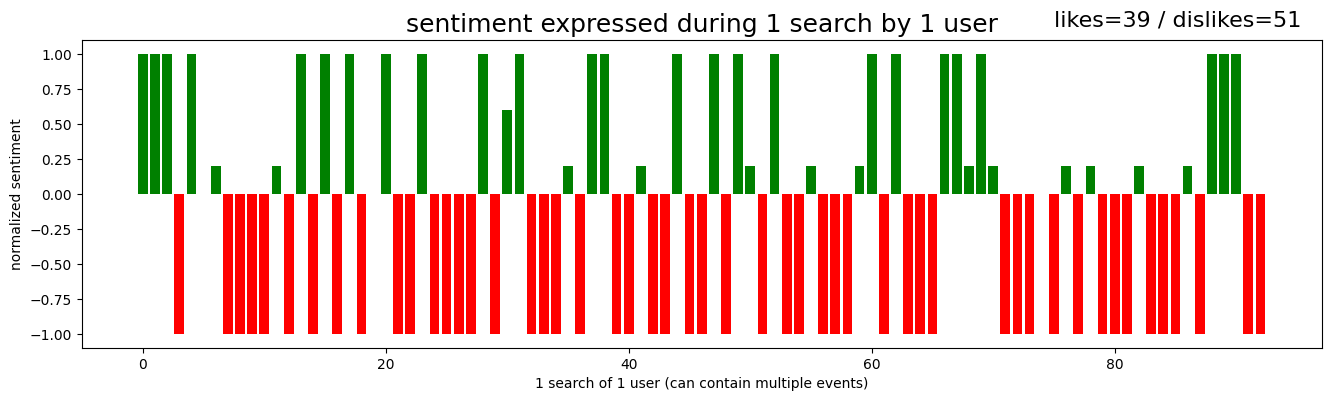

In [86]:
grouped_source_and_user = df.groupby(['source_ticket_id', 'client_id'])

event_groups_with_sentiment: dict[str, np.ndarray] = {}
for source_and_user, indices in grouped_source_and_user.indices.items():
    contains_sentiment: bool = False
    for index in indices:
        event: Event = events[index]
        if event.event_type == EventType.LIKE or event.event_type == EventType.DISLIKE:
            contains_sentiment = True
            break
    if contains_sentiment:
        event_groups_with_sentiment[source_and_user] = indices

event_groups_with_view_similar: dict[str, np.ndarray] = {}
for source_and_user, indices in grouped_source_and_user.indices.items():
    contains_view_similar: bool = False
    for index in indices:
        event: Event = events[index]
        if event.event_type == EventType.LIKE or event.event_type == EventType.DISLIKE:
            contains_view_similar = False
            break
        if event.event_type == EventType.VIEW_SIMILAR_INCIDENT:
            contains_view_similar = True
    if contains_view_similar:
        event_groups_with_view_similar[source_and_user] = indices
# non-discounted normalized sentiment: <-1, 1>, -1 strong dislike, +1 strong like
sentiments: dict[str, float] = {}
g_count = 0
for source_and_user, indices in event_groups_with_sentiment.items():
    likes = 0
    dislikes = 0

    liked_ids: set[str] = set()
    disliked_ids: set[str] = set()
    for index in indices:
        event: Event = events[index]
        if event.event_type == EventType.LIKE:
            if not event.similar_ticket_id in liked_ids:
                likes += 1
                liked_ids.add(event.similar_ticket_id)

        if event.event_type == EventType.DISLIKE:
            if event.similar_ticket_id not in liked_ids:
                disliked_ids.add(event.similar_ticket_id)
                dislikes += 1

    sentiments[source_and_user] = float((likes - dislikes) / (likes + dislikes))

# #discount undecided
# for source_and_user, indices in event_groups_with_sentiment.items():
#     undecided: bool = False
#     liked_ids: set[str] = set()
#     disliked_ids: set[str] = set()
#     for index in indices:
#         event: Event = events[index]
#
#         if event.event_type == EventType.LIKE:
#             if event.similar_ticket_id not in liked_ids:
#                 liked_ids.add(event.similar_ticket_id)
#                 continue
#
#             if event.similar_ticket_id in disliked_ids:
#                 undecided = True
#                 break
#
#         if event.event_type == EventType.DISLIKE:
#             if event.similar_ticket_id not in disliked_ids:
#                 disliked_ids.add(event.similar_ticket_id)
#                 continue
#
#             if event.similar_ticket_id in liked_ids:
#                 undecided = True
#                 break
#     if undecided:
#         sentiments[source_and_user] = 0

# discount dislikes
for source_and_user, indices in event_groups_with_sentiment.items():
    for index in indices:
        event: Event = events[index]
        if event.event_type == EventType.LIKE and sentiments[source_and_user] < 0:
            print('force')
            sentiments[source_and_user] = 0.2

# TODO:
# sentiments_sorted = sorted(sentiments, )

# discount better if dislikes led to like, not likes to dislikes
like_count = len([x for x in sentiments.values() if x > 0])
dislike_count = len([x for x in sentiments.values() if x < 0])

f, ax = plt.subplots(figsize=(16, 4))
plt.bar(range(len(sentiments)), sentiments.values(), color=['green' if x > 0 else 'red' for x in sentiments.values()])
plt.text(len(sentiments) - 18, 1.2, f"likes={like_count} / dislikes={dislike_count}", size=16)
plt.title('sentiment expressed during 1 search by 1 user', size=18)
plt.xlabel('1 search of 1 user (can contain multiple events)')
plt.ylabel('normalized sentiment')
plt.show()

Text(0.5, 1.0, 'events counts')

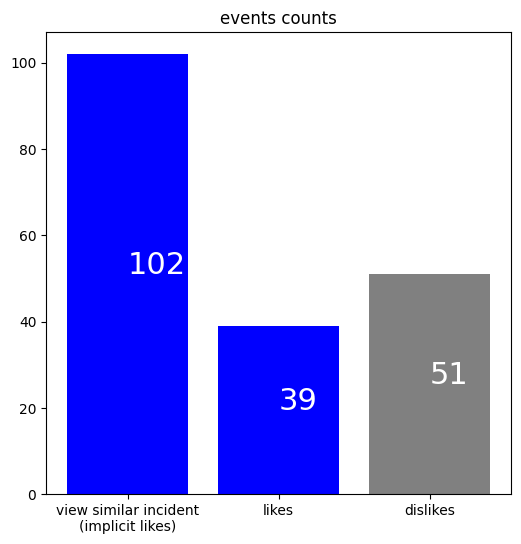

In [104]:
f, ax = plt.subplots(figsize=(6, 6))
plt.bar(
    ['view similar incident\n(implicit likes)', 'likes', 'dislikes'],
    [len(event_groups_with_view_similar), like_count, dislike_count],
    color=['blue', 'blue', 'grey']
)
plt.text(0, len(event_groups_with_view_similar) / 2, f"{len(event_groups_with_view_similar)}", size=22, color='white')
plt.text(1, like_count / 2, f"{like_count}", size=22, color='white')
plt.text(2, dislike_count / 2, f"{dislike_count}", size=22, color='white')
plt.title('events counts')

# Sentiment by assignment groups

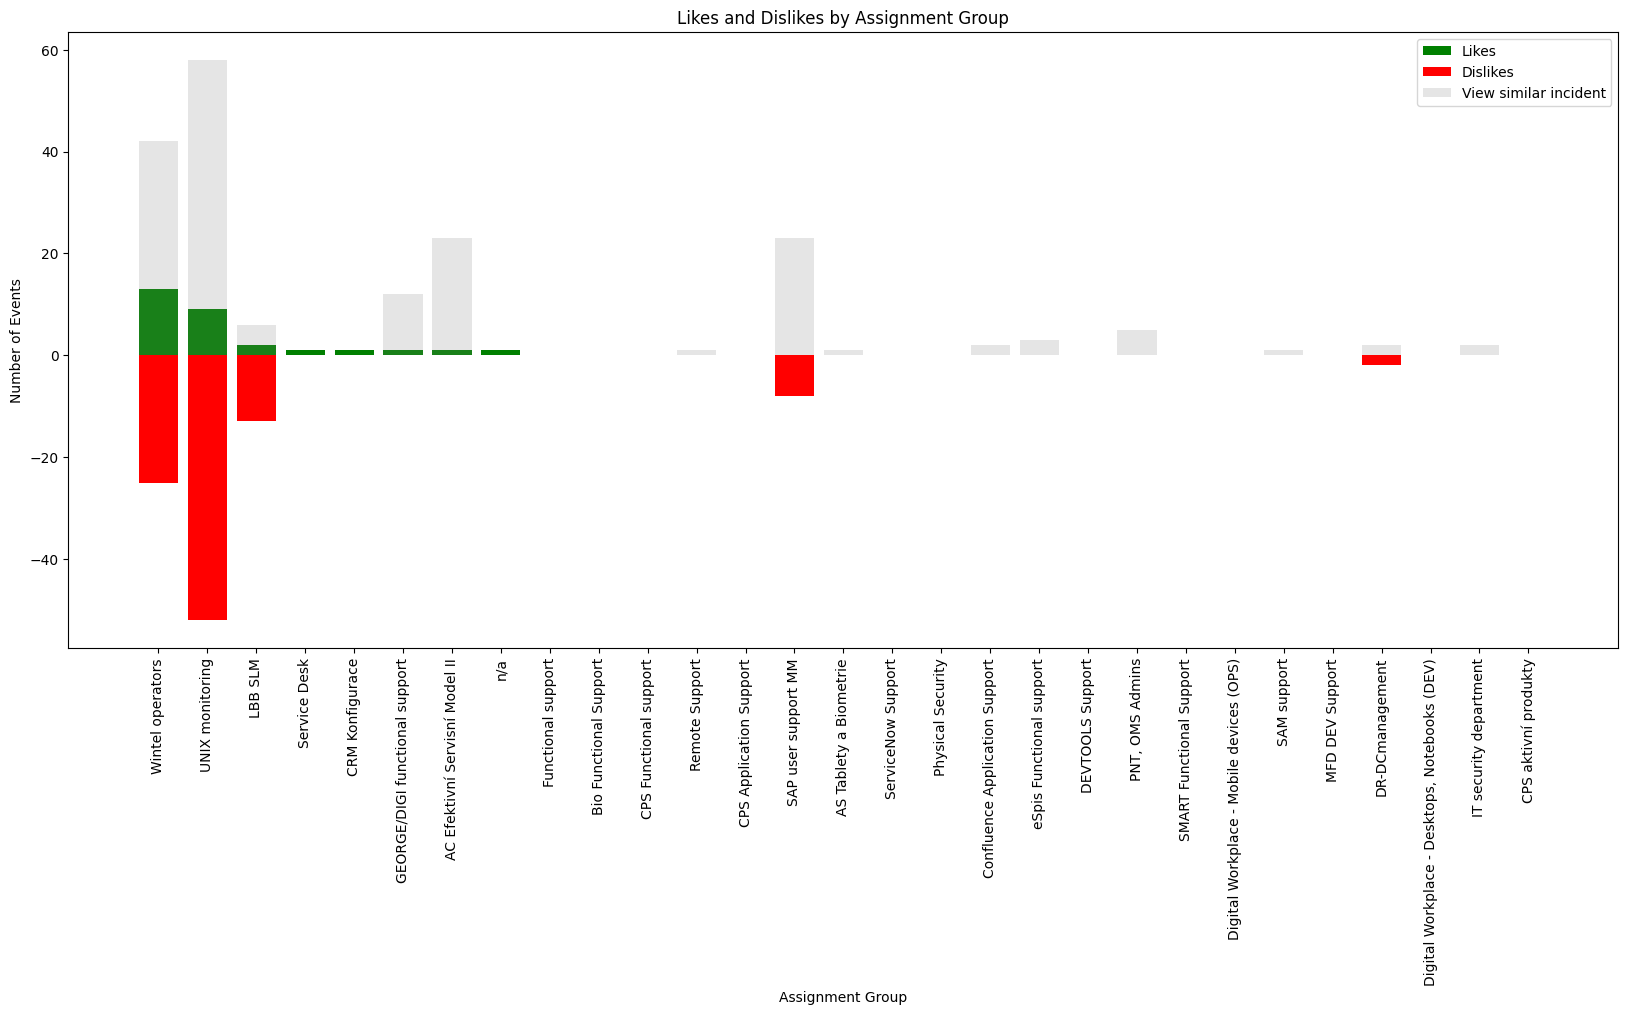

In [88]:
@dataclasses.dataclass
class Sentiment:
    likes: int
    dislikes: int
    view_similar_incident: int


unique_assignment_groups = df['assignment_group'].unique()
unique_assignment_groups = unique_assignment_groups[1:]
sentiment_assignment_groups: dict[str, Sentiment] = {assignment_group: Sentiment(0, 0, 0)
                                                     for assignment_group in unique_assignment_groups}
for event in events:
    if event.assignment_group == '':
        continue
    if event.event_type == EventType.LIKE:
        sentiment_assignment_groups[event.assignment_group].likes += 1
    if event.event_type == EventType.DISLIKE:
        sentiment_assignment_groups[event.assignment_group].dislikes += 1
    if event.event_type == EventType.VIEW_SIMILAR_INCIDENT:
        sentiment_assignment_groups[event.assignment_group].view_similar_incident += 1

sentiment_assignment_groups_sorted_by_likes = sorted(sentiment_assignment_groups.items(),
                                                     key=lambda x: x[1].likes, reverse=True)

# create lists to hold the likes and dislikes values for each assignment group
likes_values = [group[1].likes for group in sentiment_assignment_groups_sorted_by_likes]
dislikes_values = [- group[1].dislikes for group in sentiment_assignment_groups_sorted_by_likes]
view_similar_incident_values = [group[1].view_similar_incident for group in sentiment_assignment_groups_sorted_by_likes]

# set up the bar plot
f, ax = plt.subplots(figsize=(20, 8))
index = range(len(sentiment_assignment_groups_sorted_by_likes))

# plot the likes and dislikes bars side-by-side for each assignment group
rects1 = ax.bar(index, likes_values, color='g', label='Likes')
rects2 = ax.bar(index, dislikes_values, color='r', label='Dislikes')
rects3 = ax.bar(index, view_similar_incident_values, alpha=0.2, color='grey', label='View similar incident')

# add labels and title to the plot
ax.set_xlabel('Assignment Group')
ax.set_ylabel('Number of Events')
ax.set_title('Likes and Dislikes by Assignment Group')
ax.set_xticks(index)
ax.set_xticklabels(unique_assignment_groups, rotation='vertical')
ax.legend()
# display the plot
plt.show()

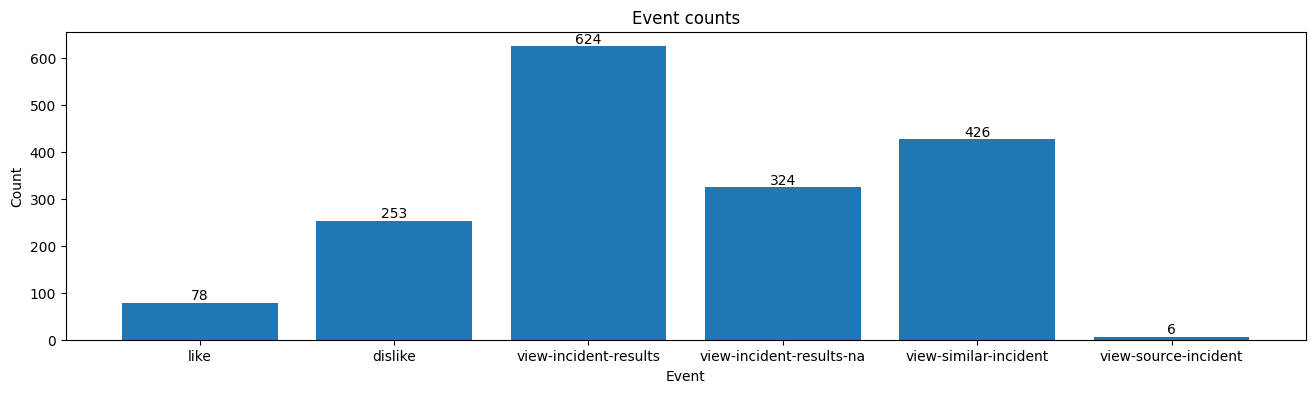

In [105]:
event_counts: dict[EventType, int] = get_event_type_counts(events)

f, ax = plt.subplots(figsize=(16, 4))
plt.bar(
    x=range(len(event_counts)),
    height=event_counts.values(),
    tick_label=[event_type.value for event_type in event_counts.keys()]
)
plt.title('Event counts')
plt.xlabel('Event')
plt.ylabel('Count')
# add the count above each bar
for i, count in enumerate(event_counts.values()):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')


Counts by dislikes

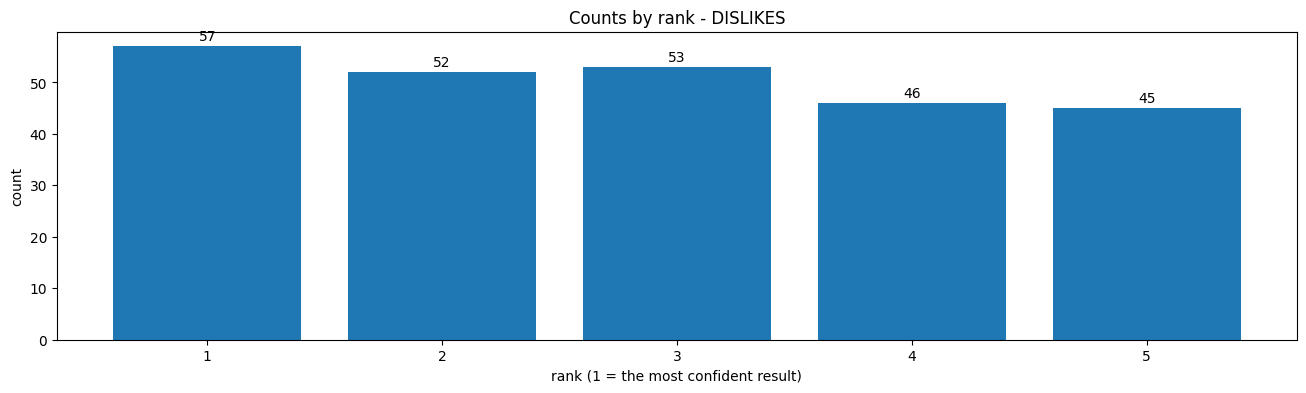

In [90]:
dislike_events: list[Event] = [event for event in events if event.event_type == EventType.DISLIKE]

rank_count_dislikes: dict[int, int] = {i: 0 for i in range(5)}
dislike_event: Event
for dislike_event in dislike_events:
    rank_count_dislikes[dislike_event.rank] += 1

f, ax = plt.subplots(figsize=(16, 4))
plt.bar(
    x=range(len(rank_count_dislikes)),
    height=rank_count_dislikes.values(),
    tick_label=list(range(1, 6))
)
plt.title('Counts by rank - DISLIKES')
plt.xlabel('rank (1 = the most confident result)')
plt.ylabel('count')
# add the count above each bar
for i, count in enumerate(rank_count_dislikes.values()):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

Counts by likes

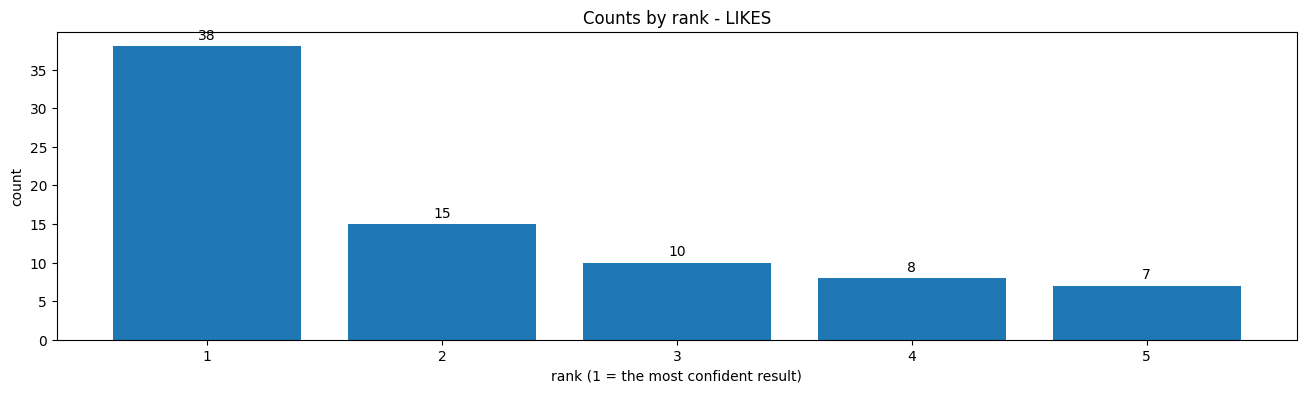

In [91]:
like_events: list[Event] = [event for event in events if event.event_type == EventType.LIKE]

rank_count_likes: dict[int, int] = {i: 0 for i in range(5)}
like_event: Event
for like_event in like_events:
    rank_count_likes[like_event.rank] += 1

f, ax = plt.subplots(figsize=(16, 4))
plt.bar(
    range(len(rank_count_likes)),
    rank_count_likes.values(),
    tick_label=list(range(1, 6))
)
plt.title('Counts by rank - LIKES')
plt.xlabel('rank (1 = the most confident result)')
plt.ylabel('count')
# add the count above each bar
for i, count in enumerate(rank_count_likes.values()):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

### User uniqueness statistics

In [92]:
df: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in events])

unique_users: pd.Series = df['client_id'].unique()

print(f"unique users {unique_users.size} from total of {len(events)} events")
print(f"uniqueness: {float(unique_users.size / len(events)) * 100:.2f}% ")

unique users 314 from total of 1711 events
uniqueness: 18.35% 


In [93]:
df_likes = pd.DataFrame.from_records([event.to_dict() for event in events
                                      if event.event_type == EventType.LIKE])

unique_likers = df_likes['client_id'].unique()

print(f"unique users {unique_likers.size} liked from total of {len(like_events)} like events")
print(f"like uniqueness: {float(unique_likers.size / df_likes.shape[0]) * 100:.2f}%")

unique users 37 liked from total of 78 like events
like uniqueness: 47.44%


In [94]:
df_dislikes: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in dislike_events
                                                       if event.event_type == EventType.DISLIKE])

unique_dislikers = df_dislikes['client_id'].unique()

print(f"unique users {unique_dislikers.size} disliked from total of {df_dislikes.shape[0]} dislike events")
print(f"dislike uniqueness: {float(unique_dislikers.size / df_dislikes.shape[0]) * 100:.2f}%")

unique users 62 disliked from total of 253 dislike events
dislike uniqueness: 24.51%


In [95]:
unique_dislikers_with_counts: pd.Series = df_dislikes['client_id'].value_counts()
OUTLIER_THRESHOLD: float = 0.05
k = int(unique_dislikers_with_counts.size * OUTLIER_THRESHOLD)
unique_dislikers_with_counts = unique_dislikers_with_counts[k:-k]

print(
    f"unique users {unique_dislikers_with_counts.size} disliked from total of {df_dislikes.shape[0] - 2 * k} dislike events, best {k} and worst {k} outliers removed ")
print(f"dislike uniqueness: {float(unique_dislikers_with_counts.size / df_dislikes.shape[0]) * 100:.2f}%")

unique users 56 disliked from total of 247 dislike events, best 3 and worst 3 outliers removed 
dislike uniqueness: 22.13%


Dislikes by unique client ids

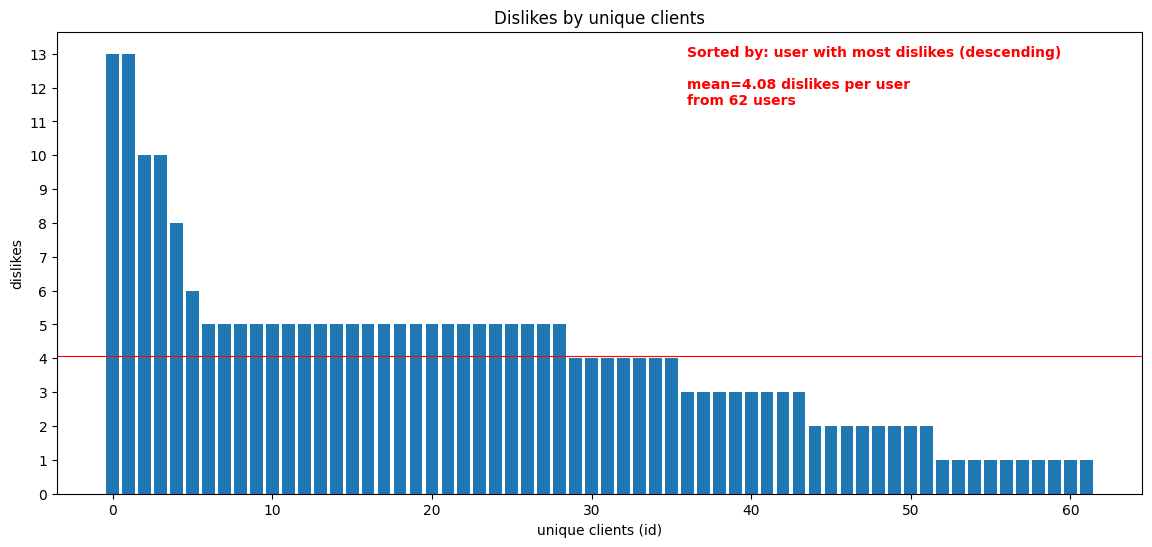

In [96]:
unique_dislikers_with_counts: pd.Series = df_dislikes['client_id'].value_counts()

f, ax = plt.subplots(figsize=(14, 6))
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(range(0, 15))
plt.title("Dislikes by unique clients")
plt.xlabel("unique clients (id)")
plt.ylabel('dislikes')
plt.bar(
    range(unique_dislikers_with_counts.size),
    unique_dislikers_with_counts
)
plt.text(36, 11.5,
         f"Sorted by: user with most dislikes (descending) \n\n"
         f"mean={unique_dislikers_with_counts.mean():.2f} dislikes per user\n"
         f"from {unique_dislikers_with_counts.size} users",
         color='red', weight='bold')
plt.axhline(unique_dislikers_with_counts.mean(), linewidth=.8, color='r')

Dislikes by unique client ids,  removing top k outliers

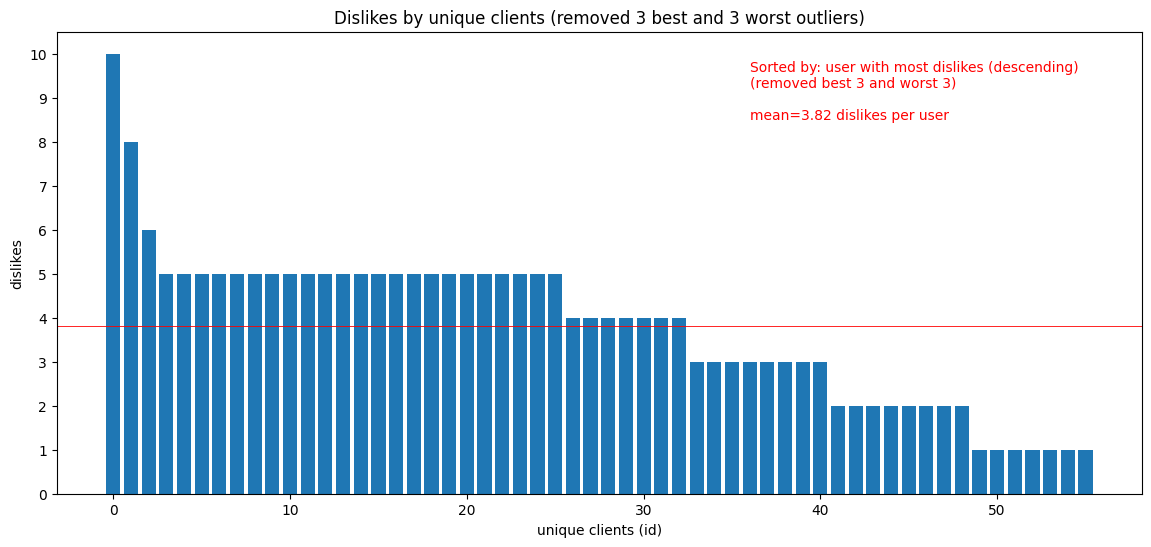

In [97]:
unique_dislikers_with_counts: pd.Series = df_dislikes['client_id'].value_counts()
OUTLIER_THRESHOLD: float = 0.05
k = int(unique_dislikers_with_counts.size * OUTLIER_THRESHOLD)
unique_dislikers_with_counts = unique_dislikers_with_counts[k:-k]

f, ax = plt.subplots(figsize=(14, 6))
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(range(0, 15))
plt.title(f"Dislikes by unique clients (removed {k} best and {k} worst outliers)")
plt.xlabel("unique clients (id)")
plt.ylabel('dislikes')
plt.bar(range(unique_dislikers_with_counts.size), unique_dislikers_with_counts)
plt.text(36, 8.5,
         f"Sorted by: user with most dislikes (descending) \n"
         f"(removed best {k} and worst {k})\n\n"
         f"mean={unique_dislikers_with_counts.mean():.2f} dislikes per user",
         color='red', )
plt.axhline(unique_dislikers_with_counts.mean(), linewidth=.6, color='r')

Likes by unique client ids

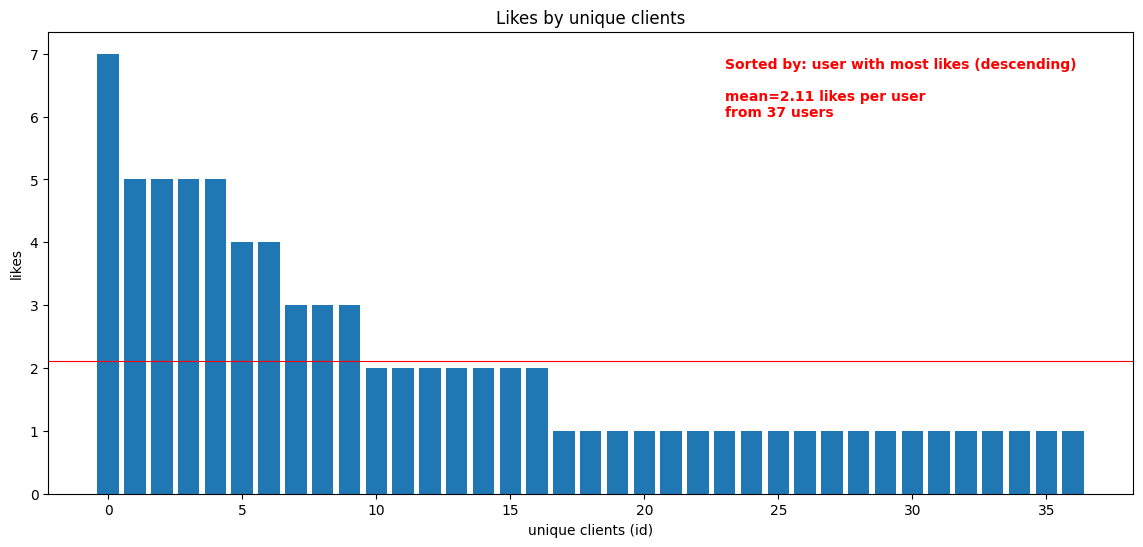

In [98]:
df_likes = pd.DataFrame.from_records([event.to_dict() for event in events
                                      if event.event_type == EventType.LIKE])

unique_likers_with_counts: pd.Series = df_likes['client_id'].value_counts()

f, ax = plt.subplots(figsize=(14, 6))
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(range(0, 10))
plt.bar(
    range(unique_likers_with_counts.size),
    unique_likers_with_counts
)
plt.title("Likes by unique clients")
plt.xlabel("unique clients (id)")
plt.ylabel('likes')

plt.text(23, 6,
         f"Sorted by: user with most likes (descending) \n\n"
         f"mean={unique_likers_with_counts.mean():.2f} likes per user\n"
         f"from {unique_likers_with_counts.size} users",
         color='red', weight='bold')
plt.axhline(float(unique_likers_with_counts.mean()), linewidth=.8, color='r')


dislike

In [99]:
df_sentiment = pd.DataFrame.from_records([event.to_dict() for event in events
                                          if
                                          event.event_type == EventType.LIKE or event.event_type == EventType.DISLIKE])

All distinct queries that got dislike.

INC50162183    10
INC50209928     9
INC50500604     8
INC49482556     5
INC50258672     5
               ..
INC50161328     1
INC50065387     1
INC50113225     1
INC50065255     1
INC50644611     1
Name: source_ticket_id, Length: 69, dtype: int64


Text(0, 0.5, 'number of dislikes)')

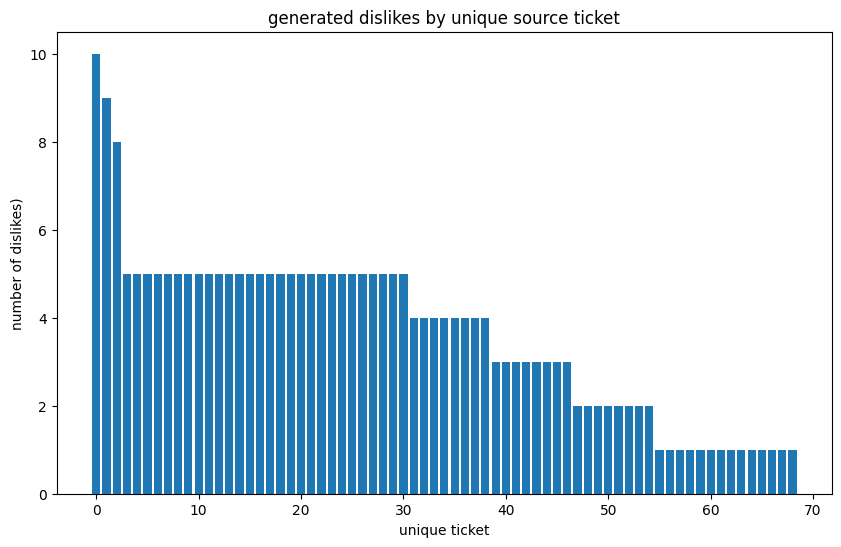

In [100]:
print(df_dislikes.source_ticket_id.value_counts())
f, ax = plt.subplots(figsize=(10, 6))
plt.bar(
    range(df_dislikes.source_ticket_id.value_counts().size),
    df_dislikes.source_ticket_id.value_counts()
)
plt.title('generated dislikes by unique source ticket')
plt.xlabel('unique ticket')
plt.ylabel('number of dislikes)')

INC50643483    6
INC50643251    5
INC50259205    5
INC50258309    5
INC45921019    5
INC50452098    4
INC50161328    4
INC50065387    3
INC46209662    3
INC50307173    2
INC50113250    2
INC50402910    2
INC50209887    2
INC50404008    2
INC50161847    2
INC50306963    1
INC48659293    1
INC46750814    1
INC50402350    1
INC50402032    1
INC50162259    1
INC50258016    1
INC50306944    1
INC50500604    1
INC50307238    1
INC46064945    1
INC50306513    1
INC50259203    1
INC50065288    1
INC50258672    1
INC50065208    1
INC47606784    1
INC50065603    1
INC50258017    1
INC50257616    1
INC50209662    1
INC50162212    1
INC49920907    1
INC49772647    1
INC49629165    1
INC50209933    1
Name: source_ticket_id, dtype: int64


Text(0, 0.5, 'number of likes)')

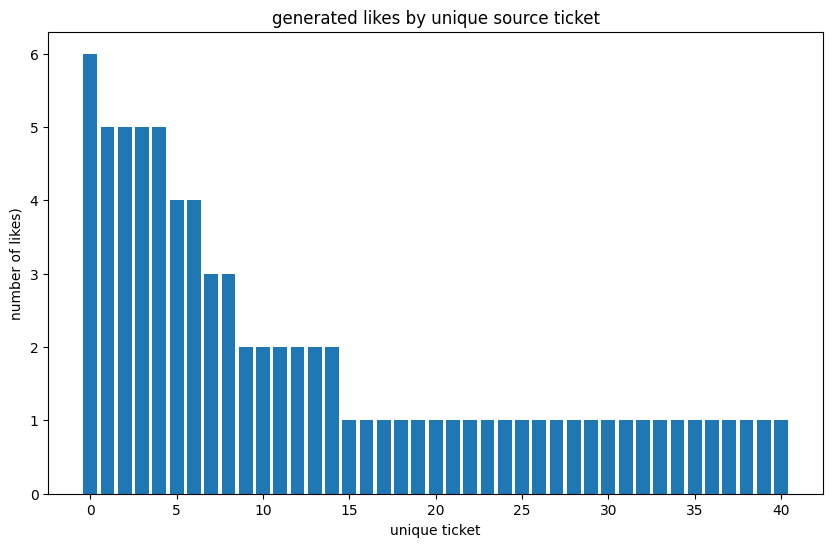

In [101]:
print(df_likes.source_ticket_id.value_counts())
f, ax = plt.subplots(figsize=(10, 6))
plt.bar(
    range(df_likes.source_ticket_id.value_counts().size),
    df_likes.source_ticket_id.value_counts()
)
plt.title('generated likes by unique source ticket')
plt.xlabel('unique ticket')
plt.ylabel('number of likes)')

Unique users for incident 'INC44915742

In [102]:
pprint(
    set(
        [event.client_id for event in events
         if event.event_type == EventType.DISLIKE and event.source_ticket_id == 'INC50162183']  # INC44915742
    )
)

{UUID('3e58bdf5-096b-4121-8264-90d92db568bd'),
 UUID('92479164-bad2-401b-bc50-179f33732aa3')}


<BarContainer object of 2 artists>

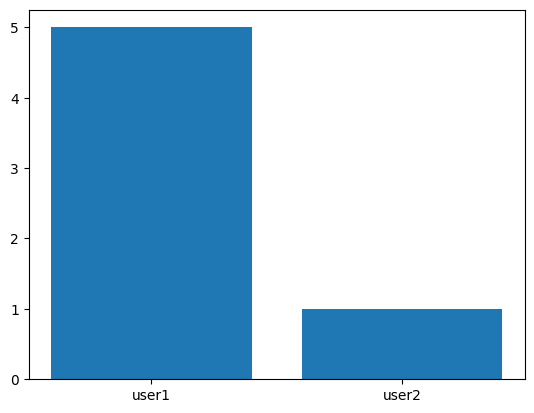

In [103]:
df_INC50643483: pd.DataFrame = pd.DataFrame.from_records(
    [event.to_dict() for event in events
     if event.event_type == EventType.LIKE and event.source_ticket_id == 'INC50643483']
)
unique_users: pd.Series = df_INC50643483['client_id'].value_counts()

plt.bar(range(unique_users.size), unique_users, tick_label=['user' + str(i) for i in range(1, unique_users.size + 1)])

plot likes that changed to dislike


plot dislikes that changed to likes